# Классификация текстов с использованием Наивного Байесовского Классификатора

## Задание 1 (1 балл)

Откройте данные. Узнайте, сколько в них спам- и не спам-писем. Визуализируйте полученные соотношение подходящим образом.

In [74]:
# импортируем библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# загружаем данные в датасет
data = pd.read_csv('data/spam_or_not_spam.csv')
data.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [20]:
# сгруппируем данные по классам и посчитаем количество сообщений в каждом
data.groupby('label')['label'].count()

label
0    2500
1     500
Name: label, dtype: int64

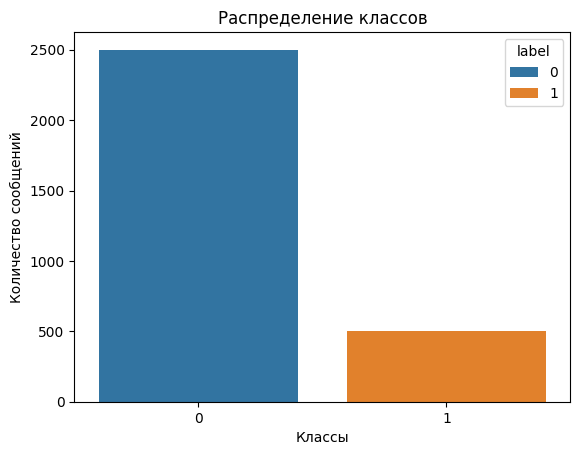

In [21]:
cp = sns.countplot(data, x='label', hue='label')
cp.set_title('Распределение классов')
cp.set_xlabel('Классы')
cp.set_ylabel('Количество сообщений');

## Задание 2 (2 балла)

Вам необходимо предобработать ваши данные и перевести их в векторный вид. Подгрузим необходимый модуль:

In [98]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
import seaborn as sns

Замените в данных все пустые строки и строки, состоящие из пробелов, на пропуски (NaN). После этого удалите из данных все строки, в которых наблюдаются пропущенные значения.

In [49]:
data.loc[data['email'] == ' ', 'email'] = np.NaN
data = data.dropna(subset='email')
data.isna().mean()

email    0.0
label    0.0
dtype: float64

Переводим данные в векторный вид:

In [50]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data["email"])

Определите, сколько теперь признаков в нашем наборе данных:

In [53]:
X.shape

(2997, 34116)

## Задание 3 (2 балла)

Определите целевую переменную и признаки:

In [54]:
x = data['email']
y = data['label']

Разделите выборку на обучающую и тестовую, используя стратифицированное разбиение (параметр `stratify` установите в значение вектора ответов y) размер тестовой выборки (`test_size`) возьмите как 0.25, параметр `random_state` определите со значением 42:

In [60]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

Рассчитайте среднее значение целевой переменной по тестовой выборке:

In [61]:
np.round(y_valid.mean(), 3)

0.165

## Задание 4 (3 балла)

Определите и обучите подходящий алгоритм с параметром alpha = 0.01

In [64]:
from sklearn.naive_bayes import ComplementNB
comp = ComplementNB(alpha=0.01)
comp.fit(X_train, y_train)
y_valid_pred = comp.predict(X_valid)

Оцените результат с точки зрения всех известных вам метрик (не менее трёх):

In [67]:
print('accuracy valid {}'.format(metrics.accuracy_score(y_valid, y_valid_pred)))
print('precision valid {}'.format(metrics.precision_score(y_valid, y_valid_pred)))
print('recall valid {}'.format(np.round(metrics.recall_score(y_valid, y_valid_pred), 3)))

accuracy valid 0.988
precision valid 1.0
recall valid 0.927


Нарисуйте ROC-кривую:

In [88]:
# предсказываем веротности отнесения к классу 1
y_cv_proba_pred = comp.predict_proba(X_valid)
y_cv_proba_pred = y_cv_proba_pred[:, 1]

In [90]:
# рассчитаем auc (площадь под кривой)
roc_auc = metrics.roc_auc_score(y_valid, y_valid_pred)
print(np.round(roc_auc, 3))

0.964


In [109]:
# рассчитаем координаты точек roc-кривой
fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_cv_proba_pred)

array([0.        , 0.        , 0.        , 0.00159744, 0.00159744,
       0.00319489, 0.00319489, 0.00638978, 0.00638978, 0.01757188,
       0.02076677, 0.02236422, 0.02715655, 0.0543131 , 0.0543131 ,
       0.07827476, 0.07827476, 0.46645367, 0.46645367, 0.97603834,
       1.        ])

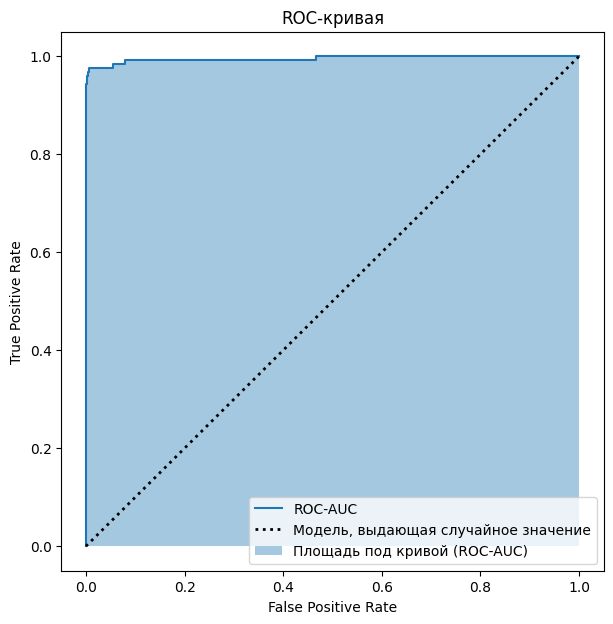

In [110]:
# построим график
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, label='ROC-AUC')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', label='Модель, выдающая случайное значение')
plt.title('ROC-кривая')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.fill_between(fpr, tpr, step="pre", alpha=0.4, label='Площадь под кривой (ROC-AUC)')
plt.legend()
plt.show();

## Задание 5 (3 балла)

Переберите несколько значений alpha с помощью кросс-валидации. Оцените, зависит ли от этого параметра качество классификации.

In [102]:
# составим списки метрик на кросс-вализации для нескольких значений alpha
alpha_range = np.linspace(0.0001, 5, 50)
f1_score = []
acc_score = []

# прогоним модель по всем значениям alpha
for alpha in alpha_range:
    comp_a = ComplementNB(alpha=alpha)
    f1 = cross_val_score(comp_a, X_train, y_train, cv=5, scoring='f1')
    acc = cross_val_score(comp_a, X_train, y_train, cv=5, scoring='accuracy')
    f1_score.append(f1.mean())
    acc_score.append(acc.mean())

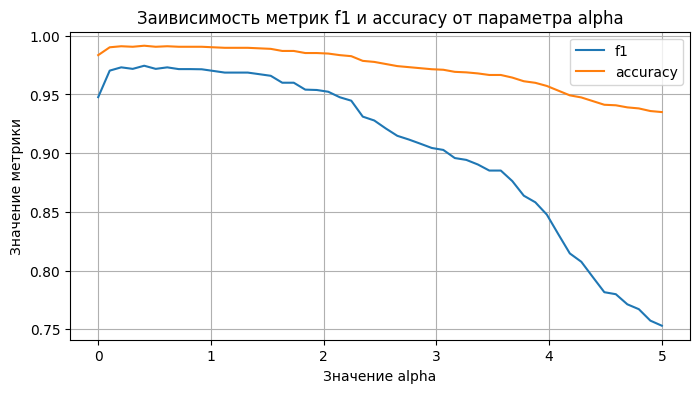

In [107]:
# построим графики
plt.figure(figsize=(8, 4))
plt.plot(alpha_range, f1_score, label='f1')
plt.plot(alpha_range, acc_score, label='accuracy')
plt.title('Заивисимость метрик f1 и accuracy от параметра alpha')
plt.xlabel('Значение alpha')
plt.ylabel('Значение метрики')

plt.legend()
plt.grid()
plt.show();

In [124]:
print('max f1 by alpha: {}'.format(np.round(alpha_range[f1_score.index(max(f1_score))], 3)))
print('max accuracy by alpha: {}'.format(np.round(alpha_range[acc_score.index(max(acc_score))], 3)))

max f1 by alpha: 0.408
max accuracy by alpha: 0.408


**Вывод:** согласно построенному графику видно, что значение параметра alpha влияет на качество модели, в диапазоне от 0,2 до 1 метрики оценки качества модели (f1 и accuracy) получаются наибольшими. При значении alpha = 0.408 получим наилучшее значение метрик.